<a href="https://colab.research.google.com/github/Sabih15/unet-reconstruction-and-segmentation/blob/master/Reconstruction_with_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Drive Mount To Access Images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Import Dependencies

In [0]:
import os
import cv2
import numpy as np
import scipy.misc
import imageio
import nibabel as nib
import keras
from keras import backend as k
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from google.colab.patches import cv2_imshow
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

###Image Directory

In [0]:
train_seg_dir = '/content/drive/My Drive/h_segmentation/train_image/images/'
mask_seg_dir = '/content/drive/My Drive/h_segmentation/train_mask/labels/'
sampled_recon_dir = '/content/drive/My Drive/heart_data/input_train/'

###Sort Images(By Name)

In [0]:
def sorting(fil):
    fil.sort()
    templist = []
    sublist = []
    m = 0
    start = 0

    for i in range(len(fil)):
        if fil[start][3:6] == fil[i][3:6]:
            templist.append(fil[i])
        else:
            sublist.append('')
            sublist[m] = templist.copy()
            m+=1
            templist.clear()
            templist.append(fil[i])
            start = i
    sublist.append('')
    sublist[m] = templist.copy()

######SORTING SECOND PART######
    for eachlist in sublist:
        for i in range(len(eachlist)):
            eachlist[i] = eachlist[i].split('.')[0]

    for ls in sublist:
        for i in range(len(ls)):
            min = int(ls[i][11:])
            minindex = i
            for j in range(i+1, len(ls)):
                if min > int(ls[j][11:]):
                    min = int(ls[j][11:])
                    minindex = j
            temp = ls[i]
            ls[i] = ls[minindex]
            ls[minindex] = temp

####ADDDING EXTENSION PNG
    for x in sublist:
        for y in range(len(x)):
            x[y] = x[y] + '.png'
    return sublist

In [0]:
n = [] 
# function used for removing nested  
# lists in python.  
def removeNesting(l): 
    for i in l: 
        if type(i) == list: 
            removeNesting(i) 
        else: 
            n.append(i)
    return n

###Read and Preprocess Reconstruction Label Data.

In [0]:
fil = os.listdir(train_seg_dir)
sorted_list = sorting(fil)
fileNames = removeNesting(sorted_list)

In [0]:
segt_X = []
for fileName in fileNames:
  segt_X.append(cv2.imread(train_seg_dir+fileName,cv2.IMREAD_GRAYSCALE))

In [0]:
segt_X = np.asarray(segt_X)
segt_X.shape

(2251, 320, 320)

In [0]:
segt_X_train = []
segt_X_val = []
segt_X_test = []

for i in range(0,1578):
    segt_X_train.append(segt_X[i])
for i in range(1578, 1796):
    segt_X_val.append(segt_X[i])
for i in range(1796,2251):
    segt_X_test.append(segt_X[i])

In [0]:
segt_X_train = np.asarray(segt_X_train)
segt_X_val = np.asarray(segt_X_val)
segt_X_test = np.asarray(segt_X_test)

segt_X_train = segt_X_train.reshape(1578,320,320,1)
segt_X_val = segt_X_val.reshape(218,320,320,1)
segt_X_test = segt_X_test.reshape(455,320,320,1)

In [0]:
segt_X_train = segt_X_train.astype('float32')
segt_X_val = segt_X_val.astype('float32')
segt_X_test = segt_X_test.astype('float32')

for i in range(1578):
    segt_X_train[i,:,:,:] /= 255.0
for i in range(218):
    segt_X_val[i,:,:,:] /= 255.0
for i in range(455):
    segt_X_test[i,:,:,:] /= 255.0

###Read and Preprocess Segmentation Label Data.

In [0]:
fil = os.listdir(mask_seg_dir)
sorted_list = sorting(fil)
fileNames = removeNesting(sorted_list)

In [0]:
segt_Y =[]
for fileName in fileNames:
  segt_Y.append(cv2.imread(mask_seg_dir+fileName,cv2.IMREAD_GRAYSCALE))

In [0]:
segt_Y = np.asarray(segt_Y)
segt_Y.shape

(4502, 320, 320)

In [0]:
segt_Y_train = []
segt_Y_val = []
segt_Y_test = []

for i in range(0,1578):
    segt_Y_train.append(segt_Y[i])
for i in range(1578, 1796):
    segt_Y_val.append(segt_Y[i])
for i in range(1796,2251):
    segt_Y_test.append(segt_Y[i])

In [0]:
segt_Y_train = np.asarray(segt_Y_train)
segt_Y_val = np.asarray(segt_Y_val)
segt_Y_test = np.asarray(segt_Y_test)

segt_Y_train = segt_Y_train.reshape(1578,320,320,1)
segt_Y_val = segt_Y_val.reshape(218,320,320,1)
segt_Y_test = segt_Y_test.reshape(455,320,320,1)

In [0]:
segt_Y_train = segt_Y_train.astype('float32')
segt_Y_val = segt_Y_val.astype('float32')
segt_Y_test = segt_Y_test.astype('float32')

for i in range(1578):
    segt_Y_train[i,:,:,:] /= 255.0
for i in range(218):
    segt_Y_val[i,:,:,:] /= 255.0
for i in range(455):
    segt_Y_test[i,:,:,:] /= 255.0

In [0]:
segt_Y_train = to_categorical(segt_Y_train)
segt_Y_val = to_categorical(segt_Y_val)
segt_Y_test = to_categorical(segt_Y_test)

###Read and Preprocess Reconstruction Training Set.

In [0]:
fil = os.listdir(train_seg_dir)
sorted_list = sorting(fil)
fileNames = removeNesting(sorted_list)

In [0]:
recon_X = []
for fileName in fileNames:
  recon_X.append(cv2.imread(sampled_recon_dir+fileName,cv2.IMREAD_GRAYSCALE))

In [0]:
recon_X = np.asarray(recon_X)
recon_X.shape

(6753, 320, 320)

In [0]:
recon_X_train = []
recon_X_val = []
recon_X_test = []

for i in range(0,1578):
    recon_X_train.append(recon_X[i])
for i in range(1578, 1796):
    recon_X_val.append(recon_X[i])
for i in range(1796,2251):
    recon_X_test.append(recon_X[i])

In [0]:
recon_X_train = np.asarray(recon_X_train)
recon_X_val = np.asarray(recon_X_val)
recon_X_test = np.asarray(recon_X_test)

recon_X_train = recon_X_train.reshape(1578,320,320,1)
recon_X_val = recon_X_val.reshape(218,320,320,1)
recon_X_test = recon_X_test.reshape(455,320,320,1)

In [0]:
recon_X_train = recon_X_train.astype('float32')
recon_X_val = recon_X_val.astype('float32')
recon_X_test = recon_X_test.astype('float32')

for i in range(1578):
    recon_X_train[i,:,:,:] /= 255.0
for i in range(218):
    recon_X_val[i,:,:,:] /= 255.0
for i in range(455):
    recon_X_test[i,:,:,:] /= 255.0

###Metrics And Other Measures

In [0]:
from keras import backend as k
def iou_coef(y_true, y_pred, smooth = 1):
    y_true = k.flatten(y_true)
    y_pred = k.flatten(y_pred)
    intersection = k.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (k.sum(y_true) + k.sum(y_pred) + smooth)

In [0]:
def tp(y_pred, y_true):
    y_pred = k.eval(k.flatten(y_pred))
    y_true = k.eval(k.flatten(y_true))
    return (k.sum(y_pred*y_true))

In [0]:
def tn(y_pred, y_true):
    y_pred = (k.flatten(y_pred))
    y_true = (k.flatten(y_true))
    op1 = (1-y_pred)
    op2 = (1-y_true)
    return (k.sum(op1*op2))

In [0]:
def fp(y_pred, y_true):
    y_pred = (k.flatten(y_pred))
    y_true = (k.flatten(y_true))
    op0 = k.sum(1 - y_true)
    op1 = (1-y_pred)
    op2 = (1- y_true)
    op3 = k.sum(op1*op2)
    return (op0 - op3)

In [0]:
def fn(y_pred, y_true):
    y_pred = (k.flatten(y_pred))
    y_true = (k.flatten(y_true))
    op0 = k.sum(y_true)
    op1 = k.sum(y_pred*y_true)
    return (op0 - op1)


###Model Definition And Compilation

In [0]:
filepath = 'best_weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min', period=20)
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=6, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
cb = [checkpoint]

In [0]:
def unet(weights = None, input_size = (320,320,1)):
  
  inp = keras.engine.input_layer.Input(input_size)
  ####ENCODER FOR RECONSTRUCTION
  c1 = Conv2D(64, (3,3), activation='relu', padding='same', name="c1a")(inp)
  c1 = BatchNormalization()(c1)
  c1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name="c1b")(c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D(pool_size=(2,2))(c1)
  
  c2 = Conv2D(128, (3,3), activation = 'relu', padding='same', name="c2a")(p1)
  c2 = BatchNormalization()(c2)
  c2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name="c2b")(c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D(pool_size=(2,2))(c2)
  p2 = Dropout(0.3)(p2)
  
  c3 = Conv2D(256, (3,3), activation = 'relu', padding='same', name="c3a")(p2)
  c3 = BatchNormalization()(c3)
  c3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name="c3b")(c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D(pool_size=(2,2))(c3)
  
  c4 = Conv2D(512, (3,3), activation = 'relu', padding='same', name="c4a")(p3)
  c4 = BatchNormalization()(c4)
  c4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name="c4b")(c4)
  c4 = BatchNormalization()(c4)
  p4 = MaxPooling2D(pool_size=(2,2))(c4)
  
  c5 = Conv2D(1024, (3,3), activation = 'relu', padding='same', name="c5a")(p4)
  c5 = BatchNormalization()(c5)
  c5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same', name="c5b")(c5)
  c5 = BatchNormalization()(c5)
  
  ####DECODER FOR RECONSTRUCTION
  u6 = Conv2DTranspose(512, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u6")(c5)
  concat6 = concatenate([u6,c4])
  c6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name="c6a")(concat6)
  c6 = BatchNormalization()(c6)
  c6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name="c6b")(c6)
  c6 = BatchNormalization()(c6)
  
  u7 = Conv2DTranspose(256, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u7")(c6)
  concat7 = concatenate([u7,c3])
  c7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name="c7a")(concat7)
  c7 = BatchNormalization()(c7)
  c7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name="c7b")(c7)
  c7 = BatchNormalization()(c7)
  
  u8 = Conv2DTranspose(128, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u8")(c7)
  concat8 = concatenate([u8,c2])
  c8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name="c8a")(concat8)
  c8 = BatchNormalization()(c8)
  c8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name="c8b")(c8)
  c8 = BatchNormalization()(c8)
  C8 = Dropout(0.3)(c8)
  
  u9 = Conv2DTranspose(64, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u9")(c8)
  concat9 = concatenate([u9,c1])
  c9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name="c9a")(concat9)
  c9 = BatchNormalization()(c9)
  c9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name="c9b")(c9)
  c9 = BatchNormalization()(c9)
  
  c10 = Conv2D(1, (1,1), activation = 'sigmoid', name="recon")(c9)

  ####ENCODER FOR SEGMENTATION
  c11 = Conv2D(64, (3,3), activation='relu', padding='same', name="c11a")(c10)
  c11 = BatchNormalization()(c11)
  c11 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name="c11b")(c11)
  c11 = BatchNormalization()(c11)
  p11 = MaxPooling2D(pool_size=(2,2))(c11)
  
  c12 = Conv2D(128, (3,3), activation = 'relu', padding='same', name="c12a")(p11)
  c12 = BatchNormalization()(c12)
  c12 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name="c12b")(c12)
  c12 = BatchNormalization()(c12)
  p12 = MaxPooling2D(pool_size=(2,2))(c12)
  p12 = Dropout(0.3)(p12)
  
  c13 = Conv2D(256, (3,3), activation = 'relu', padding='same', name="c13a")(p12)
  c13 = BatchNormalization()(c13)
  c13 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name="c13b")(c13)
  c13 = BatchNormalization()(c13)
  p13 = MaxPooling2D(pool_size=(2,2))(c13)
  
  c14 = Conv2D(512, (3,3), activation = 'relu', padding='same', name="c14a")(p13)
  c14 = BatchNormalization()(c14)
  c14 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name="c14b")(c14)
  c14 = BatchNormalization()(c14)
  p14 = MaxPooling2D(pool_size=(2,2))(c14)
  
  c15 = Conv2D(1024, (3,3), activation = 'relu', padding='same', name="c15a")(p14)
  c15 = BatchNormalization()(c15)
  c15 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same', name="c15b")(c15)
  c15 = BatchNormalization()(c15)
  
  ####DECODER FOR SEGMENTATION
  u16 = Conv2DTranspose(512, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u16")(c15)
  concat16 = concatenate([u6,c4])
  c16 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name="c16a")(concat16)
  c16 = BatchNormalization()(c16)
  c16 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', name="c16b")(c16)
  c16 = BatchNormalization()(c16)
  
  u17 = Conv2DTranspose(256, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u17")(c16)
  concat17 = concatenate([u7,c3])
  c17 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name="c17a")(concat17)
  c17 = BatchNormalization()(c17)
  c17 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', name="c17b")(c17)
  c17 = BatchNormalization()(c17)
  
  u18 = Conv2DTranspose(128, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u18")(c17)
  concat18 = concatenate([u8,c2])
  c18 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name="c18a")(concat18)
  c18 = BatchNormalization()(c18)
  c18 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', name="c18b")(c18)
  c18 = BatchNormalization()(c18)
  C18 = Dropout(0.3)(c18)
  
  u19 = Conv2DTranspose(64, (3,3), activation = 'relu', strides = (2,2), padding = 'same', name="u19")(c18)
  concat19 = concatenate([u9,c1])
  c19 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name="c19a")(concat19)
  c19 = BatchNormalization()(c19)
  c19 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name="c19b")(c19)
  c19 = BatchNormalization()(c19)
  
  c20 = Conv2D(2, (1,1), activation = 'sigmoid', name="segt")(c19)
  
  model = Model(input=inp, output=[c10,c20])

  losses = {
      'recon':'mean_squared_error',
      'segt':'binary_crossentropy'
  }
  metricss = {
      'recon':'mae',
      'segt':iou_coef
  }
  model.compile(optimizer = Adam(), loss = losses, metrics = metricss )
  if(weights):
    model.load_weights(weights)
    
  return model
  
  

In [0]:
model = unet()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


###Model Training

In [0]:
yy = [segt_X_train, segt_Y_train]
yy_val = [segt_X_val, segt_Y_val]
model_history = model.fit(x=recon_X_train,y=yy, validation_data=(recon_X_val,yy_val), batch_size = 1, verbose=2, epochs=100, callbacks=cb)



Train on 1578 samples, validate on 218 samples
Epoch 1/100
 - 194s - loss: 0.0639 - recon_loss: 0.0074 - segt_loss: 0.0565 - recon_mean_absolute_error: 0.0499 - segt_iou_coef: 0.9560 - val_loss: 0.0091 - val_recon_loss: 0.0027 - val_segt_loss: 0.0064 - val_recon_mean_absolute_error: 0.0269 - val_segt_iou_coef: 0.9967
Epoch 2/100
 - 183s - loss: 0.0111 - recon_loss: 0.0034 - segt_loss: 0.0077 - recon_mean_absolute_error: 0.0324 - segt_iou_coef: 0.9957 - val_loss: 0.0163 - val_recon_loss: 0.0029 - val_segt_loss: 0.0134 - val_recon_mean_absolute_error: 0.0322 - val_segt_iou_coef: 0.9950
Epoch 3/100
 - 183s - loss: 0.0058 - recon_loss: 0.0018 - segt_loss: 0.0040 - recon_mean_absolute_error: 0.0239 - segt_iou_coef: 0.9977 - val_loss: 0.0088 - val_recon_loss: 0.0024 - val_segt_loss: 0.0064 - val_recon_mean_absolute_error: 0.0256 - val_segt_iou_coef: 0.9971
Epoch 4/100
 - 183s - loss: 0.0041 - recon_loss: 0.0014 - segt_loss: 0.0027 - recon_mean_absolute_error: 0.0202 - segt_iou_coef: 0.9984

###Curve Plotting

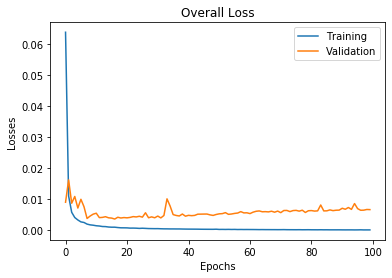

In [0]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Overall Loss')
plt.legend(['Training', 'Validation'])
plt.yscale('linear')
plt.show
plt.savefig('overall loss')

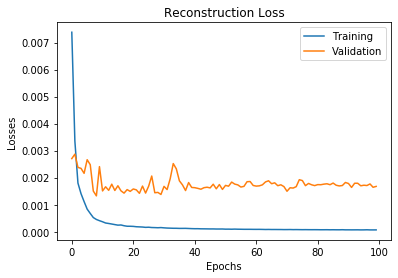

In [0]:
plt.plot(model_history.history['recon_loss'])
plt.plot(model_history.history['val_recon_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Reconstruction Loss')
plt.legend(['Training', 'Validation'])
plt.show
plt.savefig('recon loss')

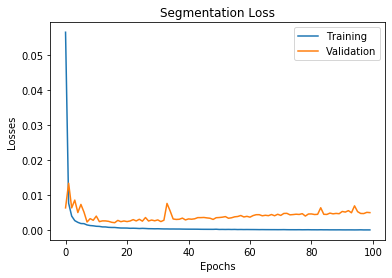

In [0]:
plt.plot(model_history.history['segt_loss'])
plt.plot(model_history.history['val_segt_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Segmentation Loss')
plt.legend(['Training', 'Validation'])
plt.show
plt.savefig('segt loss')

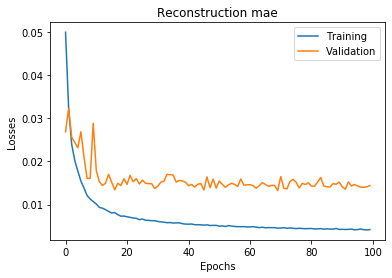

In [0]:
plt.plot(model_history.history['recon_mean_absolute_error'])
plt.plot(model_history.history['val_recon_mean_absolute_error'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Reconstruction mae')
plt.legend(['Training', 'Validation'])
plt.show
plt.savefig('mae')

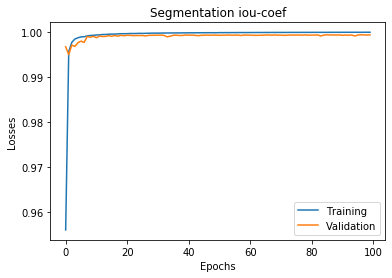

In [0]:
plt.plot(model_history.history['segt_iou_coef'])
plt.plot(model_history.history['val_segt_iou_coef'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Segmentation iou-coef')
plt.legend(['Training', 'Validation'])
plt.show
plt.savefig('iou_coef')

###Model Predictions

In [0]:
pred = model.predict(x=recon_X_test, verbose=1)

455/455 [==============================] - 15s 32ms/step


In [0]:
pred_recon = np.asarray(pred[0])
pred_segt = np.asarray(pred[1])

In [0]:
pred_recon.shape

(455, 320, 320, 1)

In [0]:
segt_Y_test_new = np.argmax(segt_Y_test, axis=3, out=None)
pred_segt_new = np.argmax(pred_segt, axis=3, out=None)

In [0]:
pred_recon_new = pred_recon.reshape(455,320,320)
segt_X_test_new = segt_X_test.reshape(455,320,320)

In [0]:
pred_recon_new = pred_recon_new.astype('float32')
pred_segt_new = pred_segt_new.astype('float32')
segt_Y_test_new = segt_Y_test_new.astype('float32')

###Original And Predicted Slices And Masks.

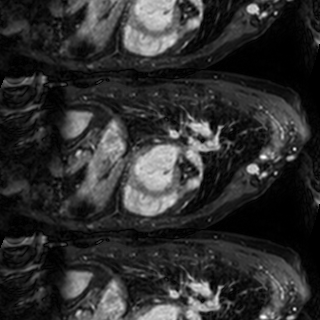

True

In [0]:
cv2_imshow(recon_X_test[382,:,:,:].reshape(320,320)*255.0)
cv2.imwrite('undersample_382.png', recon_X_test[382,:,:,:].reshape(320,320)*255.0)

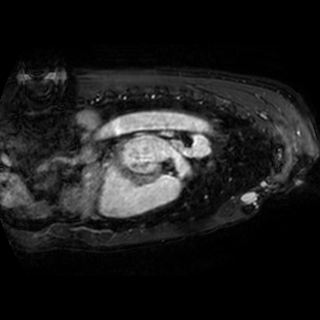

True

In [0]:
cv2_imshow(segt_X_test[50,:,:,:].reshape(320,320)*255.0)
cv2.imwrite('fullysample_50.png', segt_X_test[50,:,:,:].reshape(320,320)*255.0)

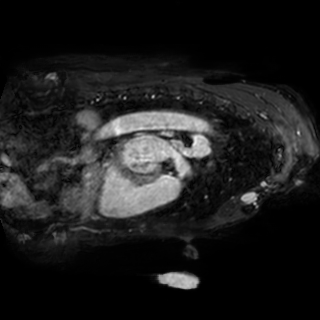

True

In [0]:
cv2_imshow(pred_recon_new[50,:,:].reshape(320,320)*255.0)
cv2.imwrite('predicted_50.png', pred_recon_new[50,:,:].reshape(320,320)*255.0)

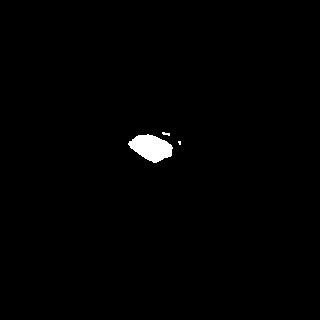

True

In [0]:
cv2_imshow(segt_Y_test_new[50,:,:].reshape(320,320)*255.0)
cv2.imwrite('segtMask_50.png', segt_Y_test_new[50,:,:].reshape(320,320)*255.0)

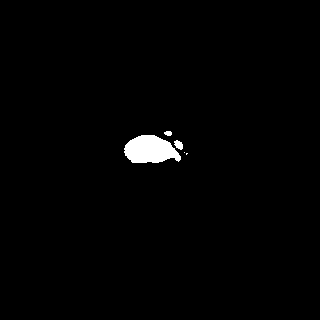

True

In [0]:
cv2_imshow(pred_segt_new[50,:,:].reshape(320,320)*255.0)
cv2.imwrite('predMask_50.png', pred_segt_new[50,:,:].reshape(320,320)*255.0)

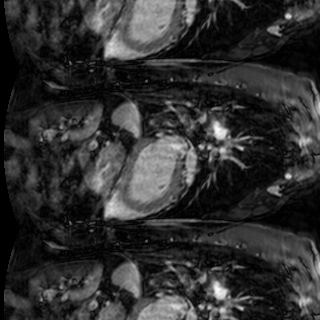

True

In [0]:
cv2_imshow(recon_X_test[162,:,:,:].reshape(320,320)*255.0)
cv2.imwrite('undersample_162.png', recon_X_test[162,:,:,:].reshape(320,320)*255.0)

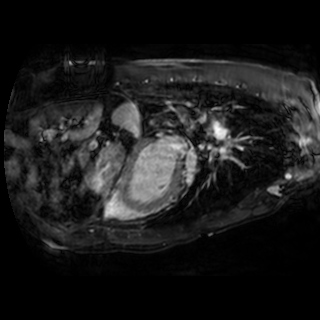

True

In [0]:
cv2_imshow(segt_X_test[162,:,:,:].reshape(320,320)*255.0)
cv2.imwrite('fullysample_162.png', segt_X_test[162,:,:,:].reshape(320,320)*255.0)

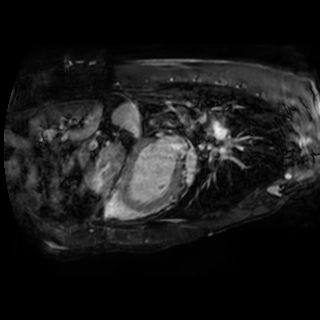

True

In [0]:
cv2_imshow(pred_recon_new[162,:,:].reshape(320,320)*255.0)
cv2.imwrite('predicted_162.png', pred_recon_new[162,:,:].reshape(320,320)*255.0)

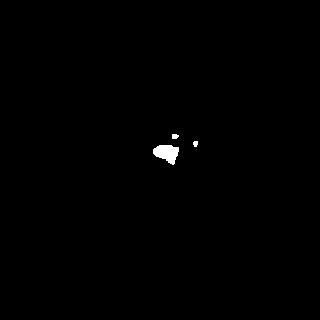

True

In [0]:
cv2_imshow(segt_Y_test_new[382,:,:].reshape(320,320)*255.0)
cv2.imwrite('segtMask_382.png', segt_Y_test_new[162,:,:].reshape(320,320)*255.0)

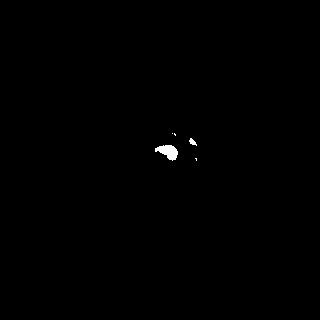

True

In [0]:
cv2_imshow(pred_segt_new[382,:,:].reshape(320,320)*255.0)
cv2.imwrite('predMask_382.png', pred_segt_new[162,:,:].reshape(320,320)*255.0)

#Metrics Calculation

##I) Segmentation

###Dice-Score

In [0]:
from keras import backend as b
dice_segt = []
for i in range(455):
  dice_segt.append(b.eval(iou_coef(segt_Y_test_new[i,:,:], pred_segt_new[i,:,:])))

In [0]:
sum=0
for i in dice_segt:
    sum+=i
sum/455

0.7886816932942595

In [0]:
dice_segt_ro = []
for i in dice_segt:
    if i < 0.5:
        dice_segt_ro.append(0)
    else:
        dice_segt_ro.append(1)

In [0]:
s/455

0.8285714285714286

In [0]:
print(np.min(dice_segt))
print(np.max(dice_segt))

0.007194245
1.0


##II) Reconstruction

###Peak Signal-To-Noise Ratio

In [0]:
p_index=[]
for i in range(455):
    p_index.append(psnr(segt_X_test[i,:,:,:], pred_recon[i,:,:,:]))

In [0]:
print(np.min(p_index))
print(np.max(p_index))

23.032189691939237
38.21621684674199


###Structural Similarity Index

In [0]:
ssim_index=[]
for i in range(455):
    ssim_index.append(ssim(segt_X_test_new[i,:,:], pred_recon_new[i,:,:]))

In [0]:
print(np.min(ssim_index))
print(np.max(ssim_index))

0.9024079009076418
0.986223964453037


In [0]:
np.mean(p_index)

32.10248881813025

In [0]:
temp = ssim_index[0:119]
print(np.mean(temp))
temp1 = ssim_index[119:238]
print(np.mean(temp1))
temp2 = ssim_index[238:346]
print(np.mean(temp2))
temp3 = ssim_index[346:455]
print(np.mean(temp3))

0.942124263107266
0.9675755579022606
0.9465756606022674
0.9682803383930754


###True-Positive, True_Negative, False-Positive, False-Negative

In [0]:
from keras import backend as k
TP = []
for i in range(455):
  TP.append(k.eval(tp(pred_segt_new[i,:,:], segt_Y_test_new[i,:,:])))

In [0]:
TN = []
for i in range(455):
  TN.append(k.eval(tn(pred_segt_new[i,:,:], segt_Y_test_new[i,:,:])))

In [0]:
FP = []
for i in range(455):
  FP.append(k.eval(fp(pred_segt_new[i,:,:], segt_Y_test_new[i,:,:])))

In [0]:
FN = []
for i in range(455):
  FN.append(k.eval(fn(pred_segt_new[i,:,:], segt_Y_test_new[i,:,:])))

In [0]:
TP[354]+FP[354]+FN[354]

0.0

###TruePositiveRate/Sensitivity/Recall

In [0]:
recall = np.sum(TP)/ ( np.sum(TP)+np.sum(FN))

###FalsePositiveRate/Fallout

In [0]:
fallout = np.sum(FP)/ ( np.sum(FP)+np.sum(TN))

###PositivePredictedValue/Precision

In [0]:
precision = np.sum(TP)/ ( np.sum(TP)+np.sum(FP))

###JaccardSimilarityCoefficient/JaccardIndex

In [0]:
JI = np.sum(TP)/ ( np.sum(TP)+np.sum(FP)+np.sum(FN))

###Informedness/YoudenIndex

In [0]:
rYI = recall-fallout